# Challenge Data Scientist - Javiera Morales

El problema que se busca solucionar en este desafío es predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile.

Iniciamos el desafío importando los paquetes de python necesarios para la resolución de este.

In [96]:
# Para trabajo con el dataset
import pandas as pd
import numpy as np
from datetime import datetime

# Para visualización de los datos
import seaborn as sns
import matplotlib.pyplot as plt

# Para realizar modelos de machine learning para resolver el problema
from sklearn import *

Primero debemos cargar el dataset entregado que cuenta con información de vuelos que despegaron y aterrizaron en el aeropuerto de Santiago.

In [12]:
dataset_scl = pd.read_csv('dataset_SCL.csv')

# Visualicemos las primeras 5 líneas del dataset (5 vuelos)
dataset_scl.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


La primera pregunta que buscamos resolver es cómo se distribuyen los datos entregados, para lo que realizaremos visualización gráfica de datos y posterior análisis cuantitativo para responder.

Text(0.5, 1.0, 'Distribución del nombre de ciudad de destino')

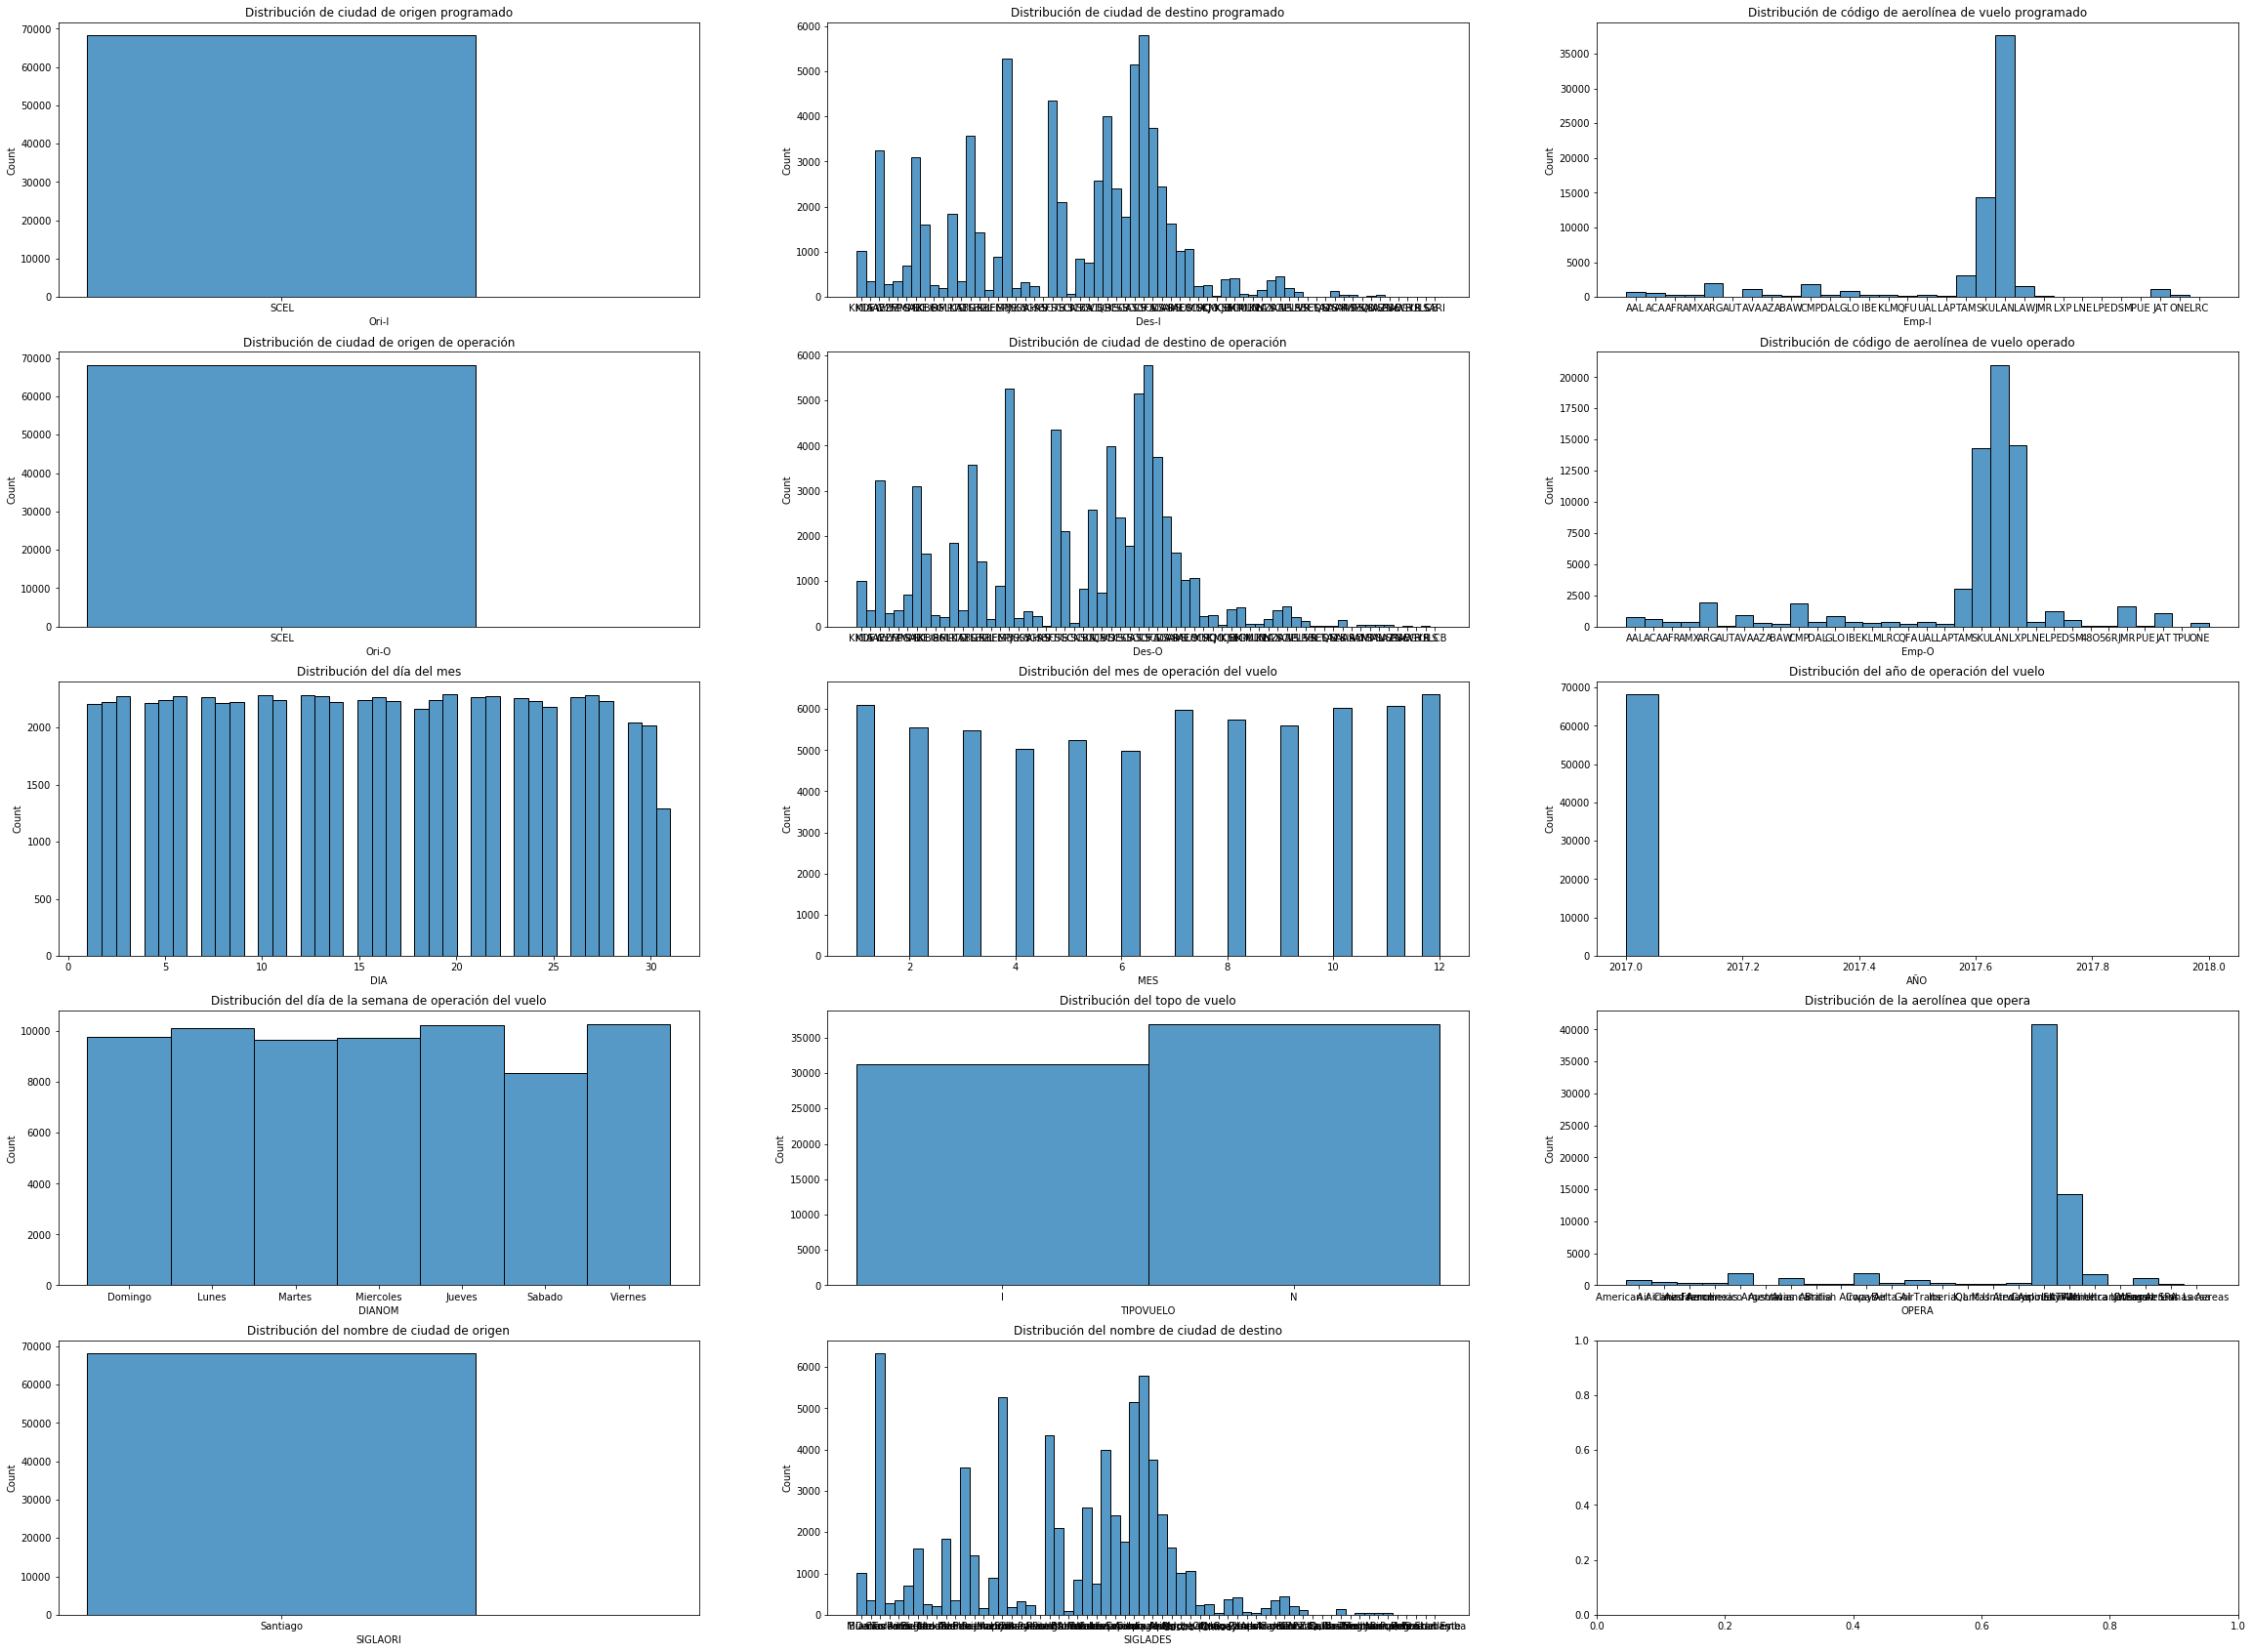

In [46]:
fig, ax = plt.subplots(5, 3, figsize = (40,30))
sns.histplot(dataset_scl['Ori-I'], ax = ax[0][0])
sns.histplot(dataset_scl['Des-I'], ax = ax[0][1])
sns.histplot(dataset_scl['Emp-I'], ax = ax[0][2])
sns.histplot(dataset_scl['Ori-O'], ax = ax[1][0])
sns.histplot(dataset_scl['Des-O'], ax = ax[1][1])
sns.histplot(dataset_scl['Emp-O'], ax = ax[1][2])
sns.histplot(dataset_scl['DIA'], ax = ax[2][0])
sns.histplot(dataset_scl['MES'], ax = ax[2][1])
sns.histplot(dataset_scl['AÑO'], ax = ax[2][2])
sns.histplot(dataset_scl['DIANOM'], ax = ax[3][0])
sns.histplot(dataset_scl['TIPOVUELO'], ax = ax[3][1])
sns.histplot(dataset_scl['OPERA'], ax = ax[3][2])
sns.histplot(dataset_scl['SIGLAORI'], ax = ax[4][0])
sns.histplot(dataset_scl['SIGLADES'], ax = ax[4][1])

ax[0][0].set_title('Distribución de ciudad de origen programado')
ax[0][1].set_title('Distribución de ciudad de destino programado')
ax[0][2].set_title('Distribución de código de aerolínea de vuelo programado')
ax[1][0].set_title('Distribución de ciudad de origen de operación')
ax[1][1].set_title('Distribución de ciudad de destino de operación')
ax[1][2].set_title('Distribución de código de aerolínea de vuelo operado')
ax[2][0].set_title('Distribución del día del mes')
ax[2][1].set_title('Distribución del mes de operación del vuelo')
ax[2][2].set_title('Distribución del año de operación del vuelo')
ax[3][0].set_title('Distribución del día de la semana de operación del vuelo')
ax[3][1].set_title('Distribución del topo de vuelo')
ax[3][2].set_title('Distribución de la aerolínea que opera')
ax[4][0].set_title('Distribución del nombre de ciudad de origen')
ax[4][1].set_title('Distribución del nombre de ciudad de destino')

De las distribuciones vistas de los datos podemos concluir que ....

Generemos ahora las variables adicionales que nos ayudarán a generar un modelo predictivo de atraso de vuelo.

In [151]:
# Primero cambiemos las variables de Fecha-I y Fecha-O a variables tipo datetime, dado que son variables tipo str.
dataset_scl['Fecha-I'] = pd.to_datetime(dataset_scl['Fecha-I'])
dataset_scl['Fecha-O'] = pd.to_datetime(dataset_scl['Fecha-O'])


# Variable temporada alta
temporada_conditions = [
    ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-07-15', '%Y-%m-%d').date()) & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-07-31', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-09-11', '%Y-%m-%d').date()) & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-09-30', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-01-01', '%Y-%m-%d').date()) & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-03-03', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-12-15', '%Y-%m-%d').date()))

]
temporada_choices = [1]
dataset_scl['temporada_alta'] = np.select(temporada_conditions, temporada_choices, default=0)

# Diferencia en minutos
dataset_scl['dif_min'] = (dataset_scl['Fecha-O']- dataset_scl['Fecha-I']).dt.total_seconds()/60

# Booleano de si está atrasado o no el vuelo por 15 minutos
dataset_scl['atraso_15'] = np.where(dataset_scl['dif_min'] > 15, 1, 0)

# Periodo del día en que ocurre el vuelo (mañana, tarde, noche) en base a Fecha-I
period_conditions = [(dataset_scl['Fecha-I'].dt.time >= datetime.strptime('05:00:00', '%H:%M:%S').time()) & (dataset_scl['Fecha-I'].dt.time <= datetime.strptime('11:59:00', '%H:%M:%S').time()),
                     (dataset_scl['Fecha-I'].dt.time >= datetime.strptime('12:00:00', '%H:%M:%S').time()) & (dataset_scl['Fecha-I'].dt.time <= datetime.strptime('18:59:00', '%H:%M:%S').time())
                     ]
period_choices = ['mañana','tarde']
dataset_scl['periodo_dia'] = np.select(period_conditions, period_choices, default='noche')


Estas variables las guardaremos ahora en un archivo de csv separado con separador ";"

In [155]:
dataset_scl[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv',sep = ';')
dataset_scl.to_csv('synthetic_features.csv',sep = ';')

,temporada_alta,dif_min,atraso_15,periodo_dia
0,1,3.0,0,noche
1,1,9.0,0,noche
2,1,9.0,0,noche
3,1,3.0,0,noche
4,1,-2.0,0,noche
...,...,...,...,...
68201,1,46.0,1,tarde
68202,1,16.0,1,tarde
68203,1,40.0,1,tarde
68204,1,13.0,0,tarde


Debemos revisar ahora el comportamiento de la tasa de atraso dependiendo de distintas variables, por destino, aerolínea, mes del año, día de la semana, temporada y tipo de vuelo. Para revisar gráficamente el comportamiento de los atrasos por las variables mencionadas se realizan boxplots, los que permiten identificar puntos atípicos (outliers) y además identificar cómo se concentran los datos en los diferentes cuartiles, donde la barra del medio de la caja corresponde a la media.

Text(0.5, 1.0, 'Tasa de atraso por tipo de vuelo')

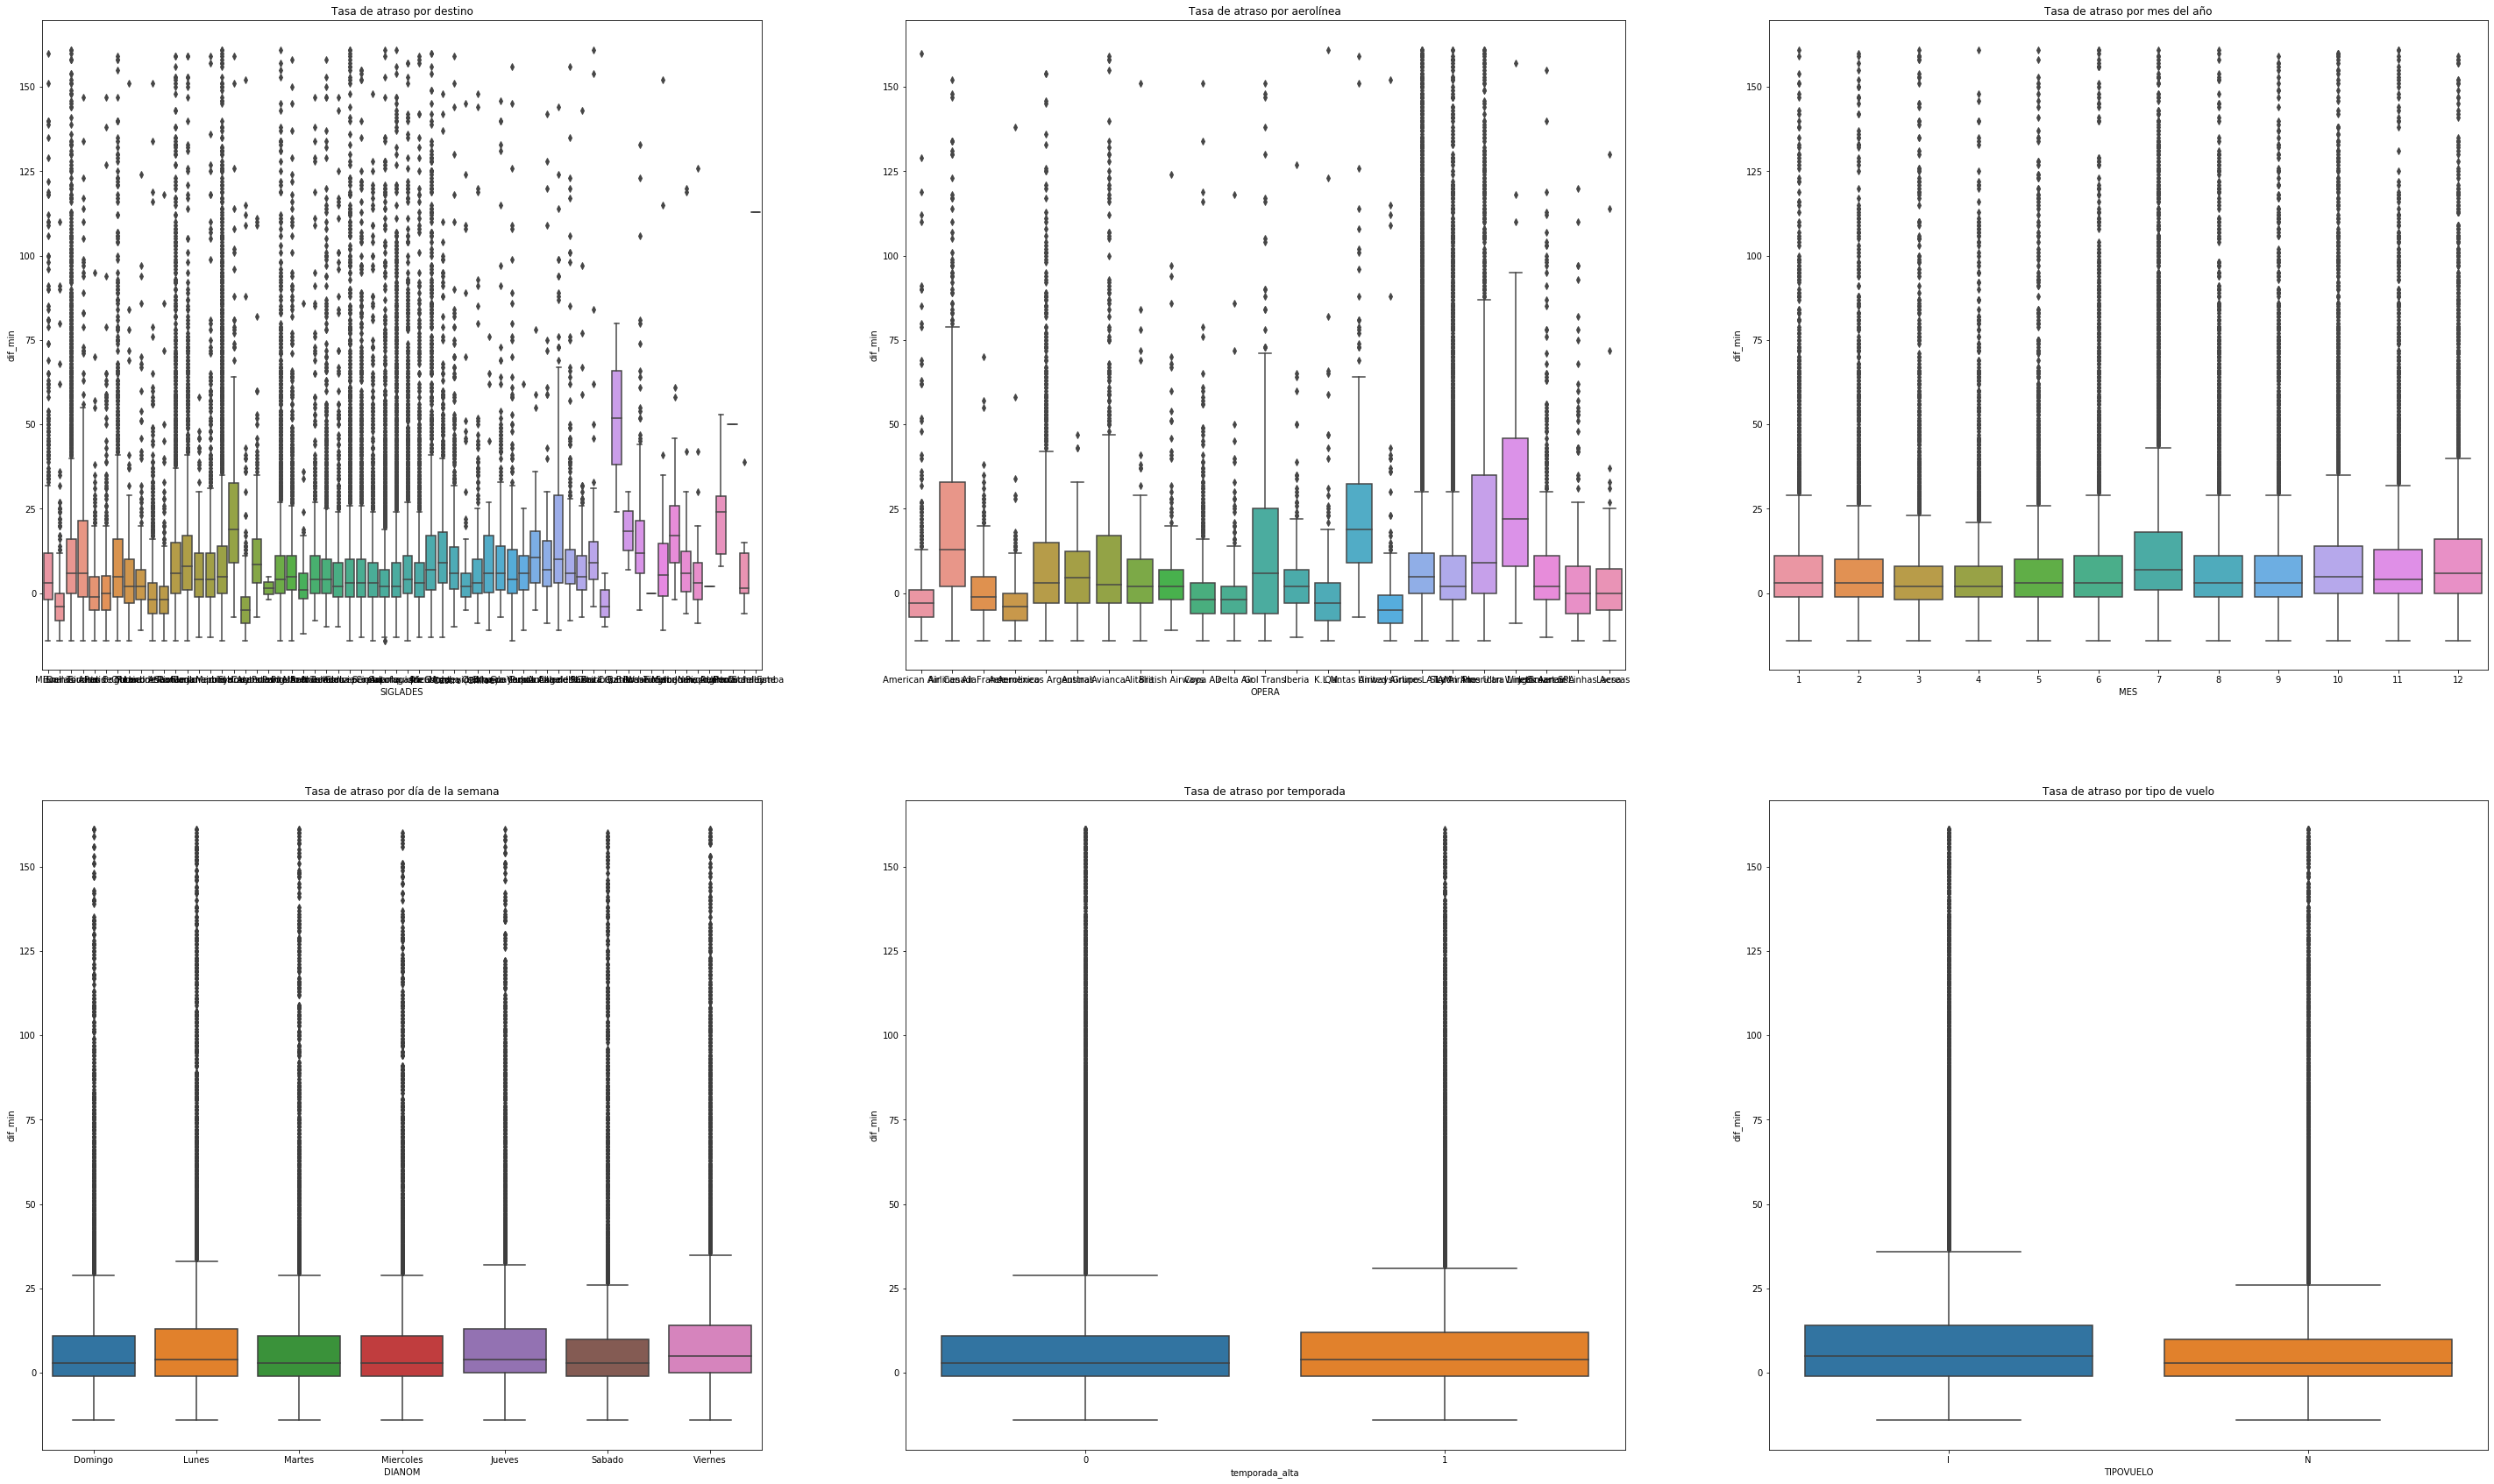

In [185]:
fig, ax = plt.subplots(2, 3, figsize = (50,30))

sns.boxplot(x='SIGLADES',y='dif_min',data=dataset_scl, ax = ax[0][0])
sns.boxplot(x='OPERA',y='dif_min',data=dataset_scl, ax = ax[0][1])
sns.boxplot(x='MES',y='dif_min',data=dataset_scl, ax = ax[0][2])
sns.boxplot(x='DIANOM',y='dif_min',data=dataset_scl, ax = ax[1][0])
sns.boxplot(x='temporada_alta',y='dif_min',data=dataset_scl, ax = ax[1][1])
sns.boxplot(x='TIPOVUELO',y='dif_min',data=dataset_scl, ax = ax[1][2])

ax[0][0].set_title('Tasa de atraso por destino')
ax[0][1].set_title('Tasa de atraso por aerolínea')
ax[0][2].set_title('Tasa de atraso por mes del año')
ax[1][0].set_title('Tasa de atraso por día de la semana')
ax[1][1].set_title('Tasa de atraso por temporada')
ax[1][2].set_title('Tasa de atraso por tipo de vuelo')

In [193]:
dataset_scl[['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO','dif_min']].groupby(['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']).min()
dataset_scl[['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO','dif_min']].groupby(['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']).mean()
dataset_scl[['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO','dif_min']].groupby(['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']).max()

dif_min
SIGLADES    OPERA           MES DIANOM    temporada_alta TIPOVUELO         
Antofagasta Grupo LATAM     1   Domingo   1              N             29.0
                                Jueves    1              N            119.0
                                Lunes     1              N             22.0
                                Martes    1              N             35.0
                                Miercoles 1              N             98.0
...                                                                     ...
Valdivia    Sky Airline     12  Miercoles 1              N             50.0
                                Sabado    1              N             29.0
                                Viernes   0              N             52.0
                                          1              N            143.0
Washington  United Airlines 8   Martes    0              I              0.0

[7780 rows x 1 columns]

Del comportamiento estudiado anteriormente podemos concluir que ....
Dicho todo lo anterior las variables que más podrían influir en la predicción de atrasos serían ... dado que ...

Continuamos ahora el desafío con la parte de entrenamiento del modelo. Para entrenar este modelo debemos considerar las variables creadas anteriormente junto con las entregadas en el dataset original.

Este modelo corresponde a un modelo de clasificación, dado que consideraremos como atraso si la diferencia en minutos entre Fecha-I y Fecha-O es de 15 minutos, tal como se creó la variable atraso_15. Por lo que utilizaremos dicha variable como target para nuestro entrenamiento y posterior validación.